In [ ]:
# tensorflow 버전 확인
import tensorflow as tf
tf.__version__

'2.3.0'

In [1]:
# 내 구글 드라이버에 연동
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# 필요한 패키지와 모듈을 불러옴
from random import randint
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# 저장해 뒀던 모델을 불러옵니다.
new_model = load_model('gdrive/My Drive/CV/Intel Image Classification/Intel_image_classification_model.h5')

new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2 (Conv2D)               (None, 146, 146, 64)      36928     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 48, 48, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 46, 46, 128)       73856     
_________________________________________________________________
conv4 (Conv2D)               (None, 44, 44, 128)       147584    
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 14, 14, 128)       0         
_________________________________________________________________
conv5 (Conv2D)               (None, 12, 12, 256)       2

In [4]:
# ImageDataGenerator 클래스를 통해 train_datagen 인스턴스를 만듭니다.
train_datagen = ImageDataGenerator( 
    zoom_range=0.2,        # 20%까지 확대
    rotation_range=10,     # 10도까지 회전
    horizontal_flip=True,  # 좌우 뒤집기  
    rescale=1./255)        # 픽셀 값을 0~1 범위로 변환

# train_datagen 인스턴스를 통해 trin dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 train_generator 객체를 생성한다
train_generator = train_datagen.flow_from_directory(
    'gdrive/My Drive/CV/Intel Image Classification/seg_train/seg_train',
    batch_size=100,      # Size of the batches of data (default: 32).
    class_mode='sparse', # Determines the type of label arrays that are returned. "sparse" will be 1D integer labels
    target_size=(150, 150))  # 이미지의 크기 재정의
 
# ImageDataGenerator 클래스를 통해 test_datagen 인스턴스를 만듭니다.
test_datagen = ImageDataGenerator(
    zoom_range=0.2,        # 20%까지 확대
    rotation_range=10,     # 10도까지 회전
    horizontal_flip=True,  # 좌우 뒤집기  
    rescale=1./255)        # 픽셀 값을 0~1 범위로 변환

# ImageDataGenerator를 통해 validation dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 test_generator 객체를 생성한다.
test_generator = test_datagen.flow_from_directory(
    'gdrive/My Drive/CV/Intel Image Classification/seg_test/seg_test',
    batch_size=100,
    class_mode='sparse',
    target_size=(150, 150))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [5]:
# label name 을 찾아 오는 함수를 정의한다.
def findKey(indices, search_value):
    for key, value in indices.items():
        if(value == search_value):
            return key
    return -1

In [ ]:
# model evaluate(모델을 평가해 봅니다)
score = new_model.evaluate(test_generator, steps=30, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test loss: 0.4735352098941803
Test accuracy: 87.03333139419556


In [6]:
# 디렉토리에서 이미지 파일들을 읽어오는 함수 정의
def get_images(directory):
    Images = []
    pred_img_cnt = 25  # 예측할 이미지를 몇개 불러 올 것인지 설정
    i = 0
    for image_file in os.listdir(directory):          # 디렉토리로부터 파일을 하나하나 불러 온다
        i += 1
        if i > pred_img_cnt: break
        else:
             image = cv2.imread(directory+r'/'+image_file) # 불러온 이미지를 openCV 로 읽어 들인다
             image = cv2.resize(image,(150,150))           # 이미지 크기 재조정
             Images.append(image)

    return Images

In [7]:
# 예측 할 이미지를 불러온다
pred_images = get_images('gdrive/My Drive/CV/Intel Image Classification/seg_pred/seg_pred')
pred_images = np.array(pred_images) * 1./255
pred_images.shape

(25, 150, 150, 3)

In [8]:
# 예측할 이미지를 우리가 만든 모델을 통해 분류 예측해 봅니다.
prediction = new_model.predict(pred_images, verbose=1)

1/1 [==============================] - 0s 5ms/step


In [13]:
np.argmax(prediction[0])

5

In [11]:
# test_generator 가 만들어 내는 이미지의 클래스 인덱스가 무엇인지 확인해 본다.

print(test_generator.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


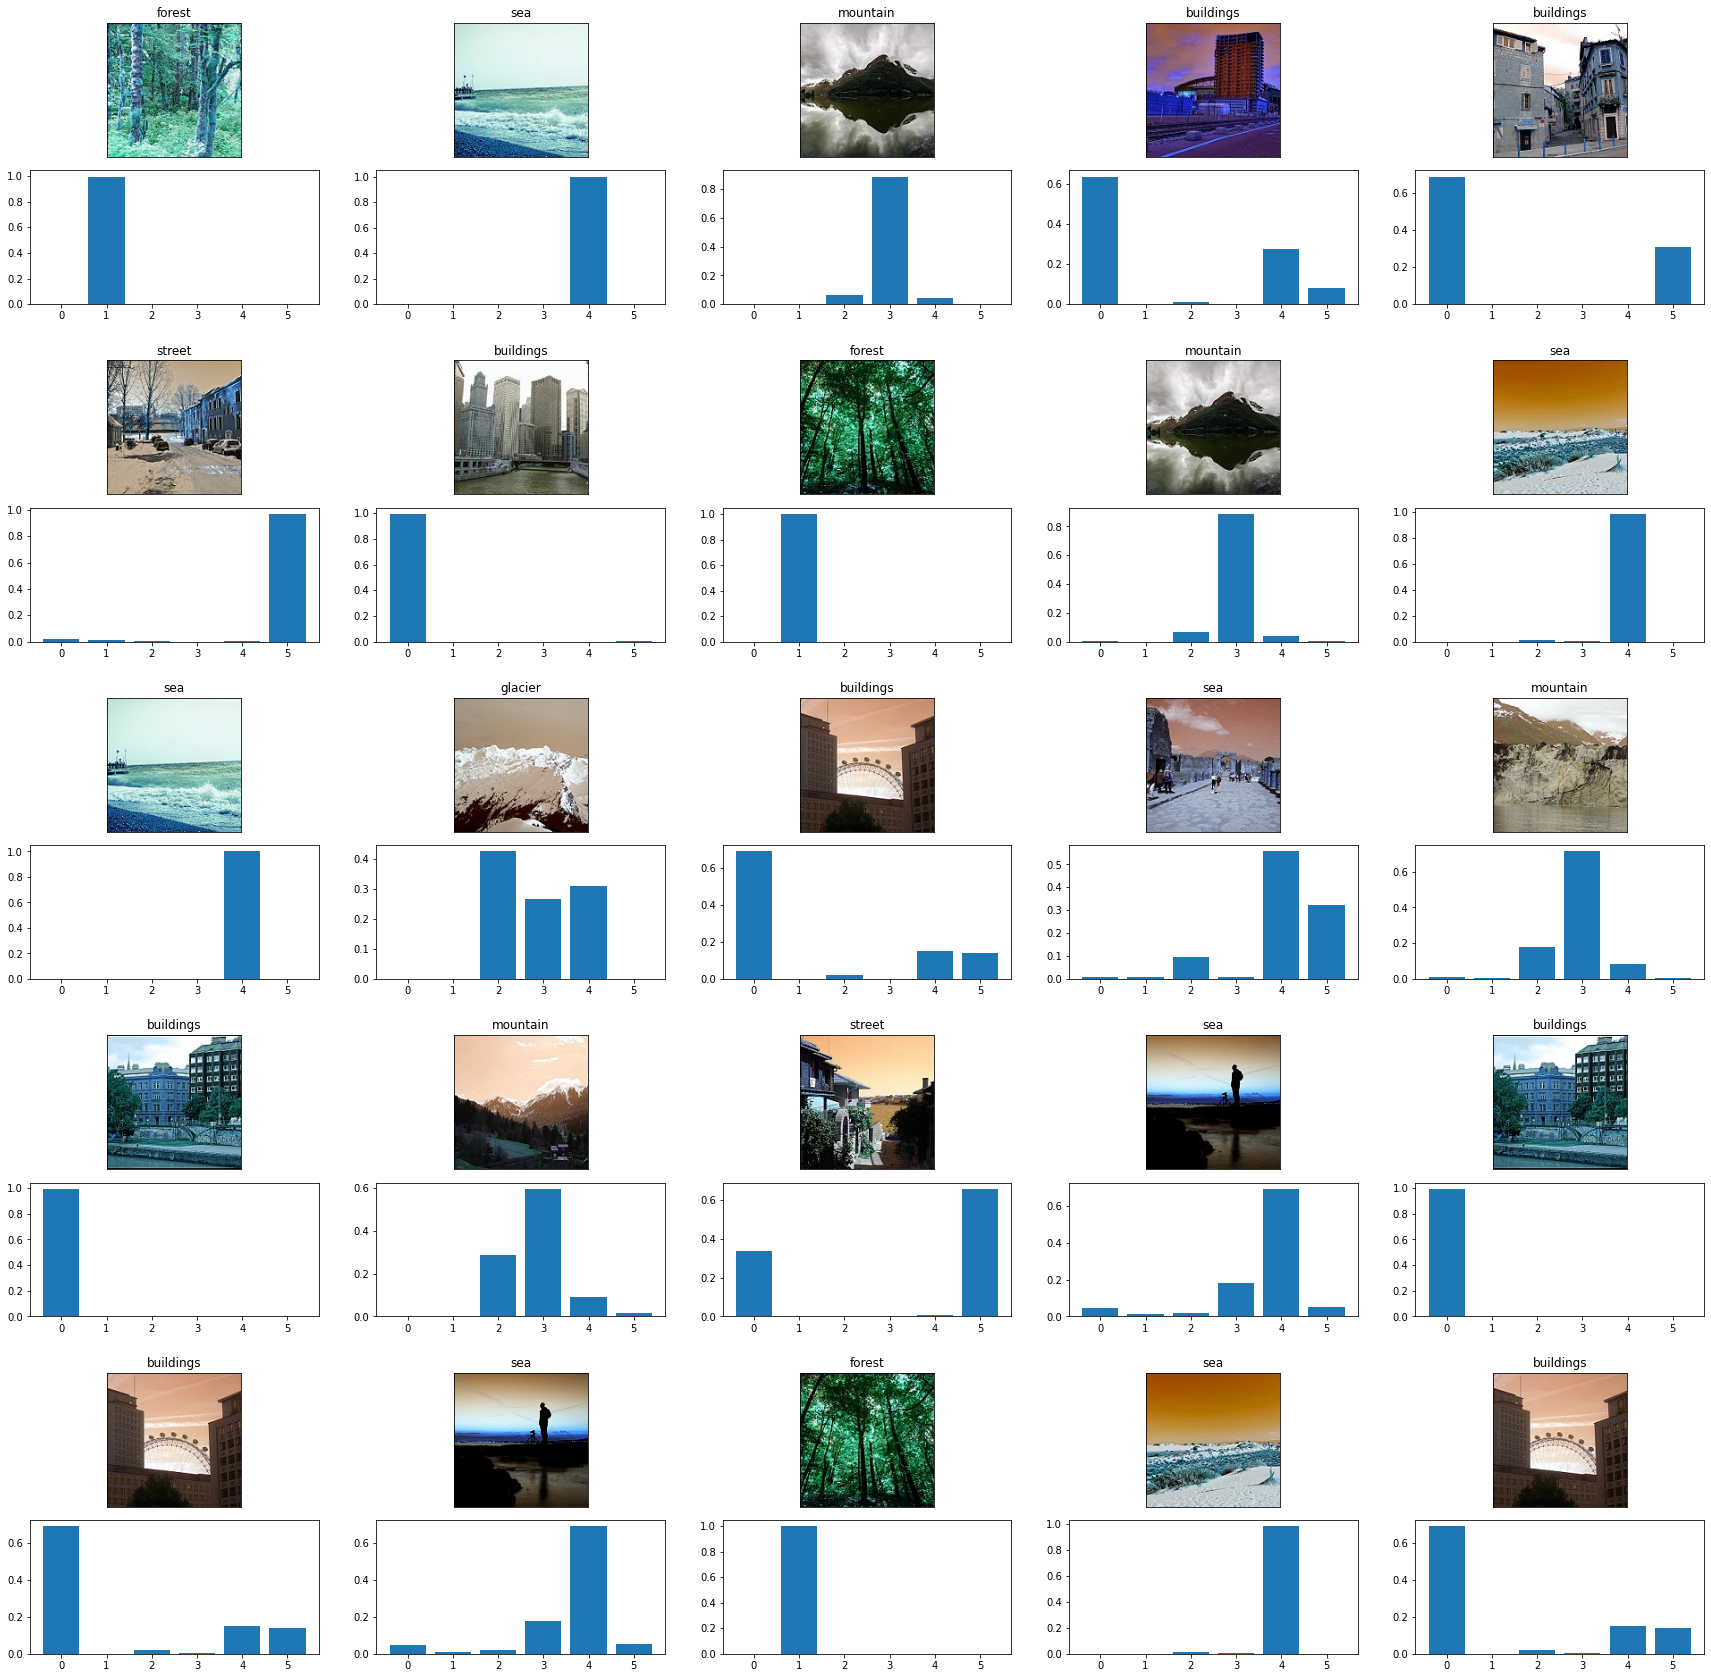

In [12]:
# 예측한 결과는 아래와 같습니다. 이미지의 위에는 class label을 이미지 아래에는 확률을 나타냅니다.

fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images)-1)
    pred_image = np.array([pred_images[rnd_number]])

    pred_class = findKey(train_generator.class_indices, np.argmax(prediction[rnd_number]))  # 이미지의 label name 을 찾아옵니다.
    pred_prob = prediction[rnd_number].reshape(6)   # 예측된 결과(확률값)를 1차원 배열(6칸)로 reshape 합니다. 
    for j in range(2):
        if (j%2) == 0:                        # 처음에는 이미지와 title(label name) 을 보여줍니다.
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:                                 # 그다음은 확률값을 그래프 형태로 보여줍니다. 
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)

fig.show()